In [124]:
library(MMWRweek)
library(ggplot2)
library(lubridate)
library("dplyr")
library("tidyr")
library(zoo)

find_median = function(values, dates, train_before="2019-10-01") {
    idx = dates < train_before
    state_deaths = data.frame(weeks=MMWRweek(data$WeekDate)$MMWRweek, values=values, dates=dates)
    median = state_deaths[idx,] %>% group_by(weeks) %>% summarise(med = median(values, na.rm=TRUE))
    merged = merge(state_deaths, median, by="weeks")
    merged$med[order(merged$dates)]
}
find_quantile = function(values, dates, q = .95, train_before="2019-10-01", before_month=6) {
    idx = dates < train_before
    state_deaths = data.frame(weeks=MMWRweek(data$WeekDate)$MMWRweek, values=values, dates=dates)
    median = state_deaths[idx,] %>% group_by(weeks) %>% summarise(est = quantile(values, probs=c(q), na.rm=TRUE))
    merged = merge(state_deaths, median, by="weeks")
    merged$est[order(merged$dates)]
}
find_sd = function(values, dates, train_before="2019-10-01", before_month=6) {
    idx = dates < train_before
    state_deaths = data.frame(weeks=MMWRweek(data$WeekDate)$MMWRweek, values=values, dates=dates)
    std = state_deaths[idx,] %>% group_by(weeks) %>% summarise(std = sd(values, na.rm=TRUE) / sqrt(length(values)))
    merged = merge(state_deaths, std, by="weeks")
    merged$std[order(merged$dates)]
}
# set path as needed

#setwd("~/RawData/OutFiles")

# Trends calculated in 2 ways:
# 1. Median quantiles
# 2. Quantile regression with week as predictor and splines as smoothers



data = read.csv("~/animal_mortality/RawData/Elmore_data.csv", sep=";")
data$Week <- sprintf("W%02d", data$Week)
data$Count = data$Outpatient_visits
head(data)


data$WeekYear <- c(paste(data$Year,data$Week,"1",sep="-"))
data$WeekDate = ISOweek::ISOweek2date((data$WeekYear))
head(data)

,Year,Week,Outpatient_visits,Count
,<int>,<chr>,<dbl>,<dbl>
1,2014,W27,0.1524,0.1524
2,2014,W28,0.1231,0.1231
3,2014,W29,0.1329,0.1329
4,2014,W30,0.1199,0.1199
5,2014,W31,0.1400,0.1400
6,2014,W32,0.1218,0.1218


,Year,Week,Outpatient_visits,Count,WeekYear,WeekDate
,<int>,<chr>,<dbl>,<dbl>,<chr>,<date>
1,2014,W27,0.1524,0.1524,2014-W27-1,2014-06-30
2,2014,W28,0.1231,0.1231,2014-W28-1,2014-07-07
3,2014,W29,0.1329,0.1329,2014-W29-1,2014-07-14
4,2014,W30,0.1199,0.1199,2014-W30-1,2014-07-21
5,2014,W31,0.1400,0.1400,2014-W31-1,2014-07-28
6,2014,W32,0.1218,0.1218,2014-W32-1,2014-08-04


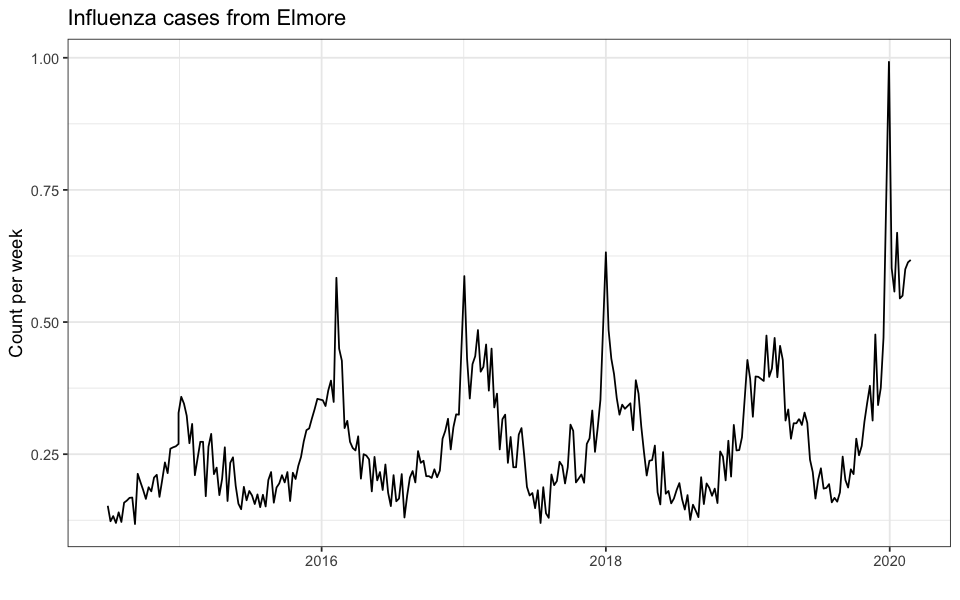

In [125]:
theme_set(theme_bw())
ggplot(data)+
  geom_line(aes(x=WeekDate,y=Outpatient_visits))+
scale_x_date(#limits = c(as.Date("2019-01-01"), NA),
    date_breaks = '2 year', date_labels = '%Y')+
  labs(title = 'Influenza cases from Elmore',
       #subtitle ='',
       #caption = '',
       x = '', y="Count per week")

In [126]:
data = data %>% mutate(ma=rollapply(log(Count, base = exp(1)),6,mean,align='center',fill=NA))

data_centered = data %>% reframe(
    ma = ma,
    Count=Count,
    logcount = log(Count),
    median = find_median(ma, WeekDate),
    std = find_sd(ma, WeekDate),
    upper = find_quantile(ma, WeekDate, q=0.975),
    lower = find_quantile(ma, WeekDate, q=0.025),
    WeekDate = WeekDate)
data_centered$centered = exp(data_centered$ma - data_centered$median) - 1
data_centered$centered_high = exp(data_centered$ma - (data_centered$lower)) - 1
data_centered$centered_low = exp(data_centered$ma - (data_centered$upper)) - 1
head(data_centered)

,ma,Count,logcount,median,std,upper,lower,WeekDate,centered,centered_high,centered_low
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<date>,<dbl>,<dbl>,<dbl>
1,NA,0.1524,-1.881247,-1.785662,0.03077556,-1.641752,-1.815982,2014-06-30,NA,NA,NA
2,NA,0.1231,-2.094758,-1.775703,0.03001124,-1.663000,-1.847790,2014-07-07,NA,NA,NA
3,-2.031125,0.1329,-2.018158,-1.817454,0.05213616,-1.670569,-2.015458,2014-07-14,-0.1923855,-0.0155441237,-0.3027109
4,-2.024794,0.1199,-2.121097,-1.818181,0.04637279,-1.698275,-2.002458,2014-07-21,-0.1866658,-0.0220889612,-0.2785694
5,-1.978822,0.1400,-1.966113,-1.791221,0.04326986,-1.711608,-1.968420,2014-07-28,-0.1710546,-0.0103480686,-0.2344909
6,-1.940357,0.1218,-2.105375,-1.753066,0.04428493,-1.688759,-1.939561,2014-08-04,-0.1707974,-0.0007956625,-0.2224425


Warning message:
“Removed 5 rows containing missing values (`geom_line()`).”
Warning message:
“Removed 5 rows containing missing values (`geom_line()`).”


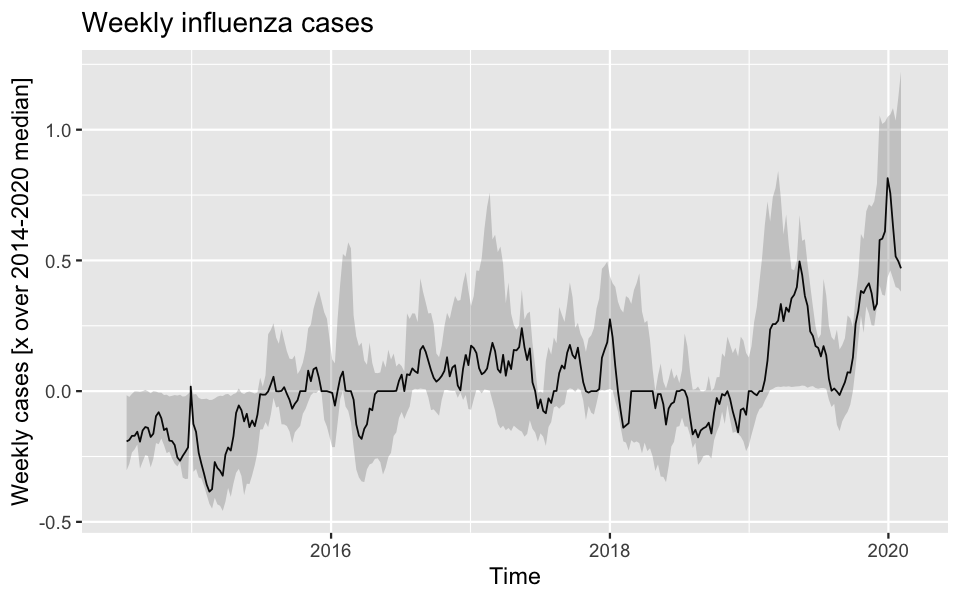

In [127]:
options(repr.plot.width=8, repr.plot.height=5)
b = ggplot(data_centered, aes(x=WeekDate, y=centered)) + geom_line() +
 geom_ribbon(aes(ymin=centered_low, ymax=centered_high), alpha = 0.2) +
 labs(x = "Time", y = "Weekly cases [x over 2014-2020 median]", title="Weekly influenza cases") + 
theme_gray(base_size = 14) 
b
ggsave("excessElmore.png", width=8, height=5)

Warning message:
“Removed 5 rows containing missing values (`geom_line()`).”


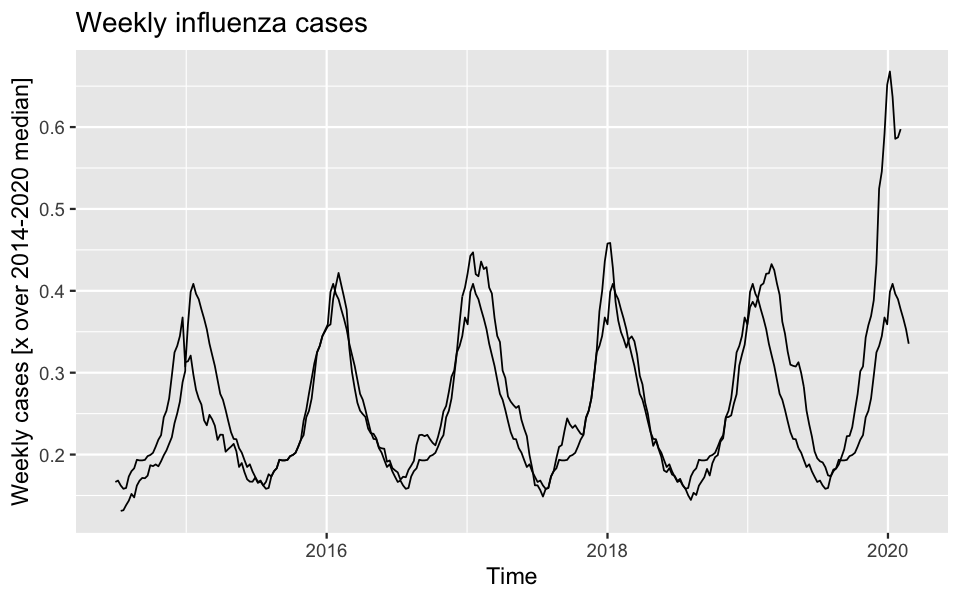

In [117]:
# Plot moving average compared with weekly median
options(repr.plot.width=8, repr.plot.height=5)
b = ggplot(data_centered, aes(x=WeekDate, y=exp(ma))) + geom_line() +
    geom_line(aes(x=WeekDate, y=exp(median))) +
 # geom_ribbon(aes(ymin=centered_low, ymax=centered_high), alpha = 0.2) +
 labs(x = "Time", y = "Weekly cases [x over 2014-2020 median]", title="Weekly influenza cases") + 
theme_gray(base_size = 14) 
b
